# Predicting Future Sales
## Data Exploration and Cleaning Note Book

**Table of contents**
<br>Notebook Setup
1. Exploration and Cleaning<br>
    1.1 Check Characteristic values<br>
    1.2 Check Key Figure values<br>
2. Exploratory Analysis<br>
    2.1 Sales General Trend - Heat Map<br>
    2.2 Items<br>
    2.3 Shop<br>
    2.4 Category<br>

## Notebook setup

In [1]:
import pandas as pd
import matplotlib.pyplot as plt # basic plotting
import seaborn as sns # for prettier plots
import numpy as np
import calmap
import math
import calmap

### Data Manipulation Options

You may change the value below to remove or keep the data as is <br>
REMOVE_NEGATIVE_COUNTS: Remove Negative item_cnt_day <br>
REMOVE_NONREV_PRODUCT: Remove product that is not relevant to prediction <br>
REMOVE_NON_PREDICT_ITM: Remove the item(s) that is not required for prediction <br>

Please note that changing these parameter will impact the some of the 
result below because some data set is removed after changing the value

In [2]:
REMOVE_NEGATIVE_COUNTS = False
REMOVE_NEGATIVE_PRICE = False
REMOVE_NON_PREDICT_ITM = False

## 1. Exploration and Cleaning

In [3]:
sales = pd.read_csv("sales_train.csv")
items = pd.read_csv("items.csv")
categories = pd.read_csv("item_categories.csv")
shops = pd.read_csv("shops.csv")
test = pd.read_csv("test.csv")

In [4]:
#check sales
sales.date.describe()
sales.sort_values(by='date')
sales

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0
2935845,09.10.2015,33,25,7460,299.00,1.0
2935846,14.10.2015,33,25,7459,349.00,1.0
2935847,22.10.2015,33,25,7440,299.00,1.0


### 1.1 Check Characteristic values

**1.1.1 Sales**

In [5]:
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [6]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


Check for null value

In [7]:
sales.isna().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

<br>
From first 5 rows, we can already infer that there is data quality issue:

There is a negative value showing in the itm_cnt_day field. 

Let's remove the negative value if required (can be configure at the Data 
Manipulation Options section above)
<br>

In [8]:
if REMOVE_NEGATIVE_COUNTS:
    sales = sales[sales.item_cnt_day >= 0]
if REMOVE_NEGATIVE_PRICE:
    sales = sales[sales.item_price >= 0]
if REMOVE_NON_PREDICT_ITM: 
    testUniID = list(test.item_id.unique())

    for idx in items.index:
        id = items.loc[idx, "item_id"]
        items.loc[idx, "Required"] = id in testUniID
# pre merge to removed data that are not related for prediction
# will drop the "Required" column for cleaner data. 
    sales = sales.merge(items, how="left", on="item_id")
    
    sales = sales[sales.Required == True]
    
# Drop column for cleaner data
    sales = sales.iloc[:, 0:6]

print()    
print("Total Number of rows for sales data frame: {}".format(len(sales))) 
print()
sales.head()


Total Number of rows for sales data frame: 2935849



,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


Let's check whether sales have duplicate data 

In [9]:
print("number of duplicates : {}".format(
    sales.duplicated(subset=["date", "shop_id", "item_id"]).sum()))

checksales = sales[sales.duplicated(subset=["date", "shop_id", 
                                            "item_id"], keep=False)].copy()

checksales.sort_values(by = ["item_id","shop_id"])

number of duplicates : 28


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
1496765,23.03.2014,14,21,3423,999.00,1.0
1496766,23.03.2014,14,21,3423,999.00,1.0
1866322,12.07.2014,18,25,3423,999.00,1.0
1866340,12.07.2014,18,25,3423,999.00,1.0
1435365,23.02.2014,13,50,3423,999.00,1.0
1435367,23.02.2014,13,50,3423,999.00,1.0
1671872,01.05.2014,16,50,3423,999.00,1.0
1671873,01.05.2014,16,50,3423,999.00,1.0
2272100,26.12.2014,23,17,3424,999.00,2.0
2272101,26.12.2014,23,17,3424,1199.00,1.0


Let's check whether all the duplicate data is required for prediction (appear in test.csv) or not.

In [10]:
testUniID = list(test.item_id.unique())

for idx in checksales.index:
    id = checksales.loc[idx, "item_id"]
    checksales.loc[idx, "Required"] = id in testUniID

#checksales[checksales.Required == False]
checksales

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,Required
6959,29.01.2013,0,25,12133,889.00,1.0,False
6960,29.01.2013,0,25,12133,1389.00,1.0,False
70686,25.01.2013,0,31,14050,349.00,1.0,False
70718,25.01.2013,0,31,14050,248.00,1.0,False
76961,05.01.2013,0,54,20130,149.00,1.0,False
76962,05.01.2013,0,54,20130,149.00,1.0,False
103461,27.01.2013,0,38,15702,549.00,1.0,True
103463,27.01.2013,0,38,15702,149.00,-1.0,True
142696,18.02.2013,1,16,15702,149.00,1.0,True
142697,18.02.2013,1,16,15702,549.00,1.0,True


The difference betweeen the duplicate data is not far so we will keep the duplicate data.

Let's check on the date format

In [11]:
sales.date.describe()

count        2935849
unique          1034
top       28.12.2013
freq            9434
Name: date, dtype: object

Let's convert the date to correct format

In [12]:
sales['date'] = pd.to_datetime(sales['date'], dayfirst = True)

sales.date.describe()

count                 2935849
unique                   1034
top       2013-12-28 00:00:00
freq                     9434
first     2013-01-01 00:00:00
last      2015-10-31 00:00:00
Name: date, dtype: object

The data is now in time stamp format

**1.1.2 Items**

In [13]:
print()
print("Total Number of rows for items data frame: {}".format(len(items)))
print()
items.head()


Total Number of rows for items data frame: 22170



,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [14]:
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22170 entries, 0 to 22169
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   item_name         22170 non-null  object
 1   item_id           22170 non-null  int64 
 2   item_category_id  22170 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 519.7+ KB


Let's check on the item_name for Russian Name. The item_name duplication will also
exclude item_name that are duplicate but different category. 

In [15]:
checkitems = items[items.duplicated(
    subset=["item_name", "item_category_id"], keep=False)].copy()

checkitems

,item_name,item_id,item_category_id


No duplication found for Russian item_name

**1.1.3 Categories**

In [16]:
print()
print("Total Number of rows for categories data frame: {}".format(len(categories))) 
print()
categories.head()


Total Number of rows for categories data frame: 84



,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [17]:
categories.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   item_category_name  84 non-null     object
 1   item_category_id    84 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.4+ KB


Let's check duplicates on the categories name

In [18]:
print("number of duplicates : {}".format(
    categories.duplicated(subset=["item_category_name"]).sum()))

number of duplicates : 0


**1.1.4 Shops**

In [19]:
print()
print("Number of rows for sales data frame : {:,.0f}".format(len(shops)))
shops.head()


Number of rows for sales data frame : 60


,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [20]:
shops.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   shop_name  60 non-null     object
 1   shop_id    60 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ KB


<br>
Let's check duplicaton for shops
<br><br>

In [21]:
print("number of duplicates : {}".format(shops.duplicated().sum()))

number of duplicates : 0


### 1.2 Check Key Figure values

**1.2.1 Normalise all data for further analysis**

In [22]:
normData = sales.merge(shops, how="left", on="shop_id")
normData = normData.merge(items, how="left", on="item_id")
normData = normData.merge(categories, how="left", on="item_category_id")
normData.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_name,item_category_id,item_category_name
0,2013-01-02,0,59,22154,999.00,1.0,"Ярославль ТЦ ""Альтаир""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
1,2013-01-03,0,25,2552,899.00,1.0,"Москва ТРК ""Атриум""",DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил
2,2013-01-05,0,25,2552,899.00,-1.0,"Москва ТРК ""Атриум""",DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил
3,2013-01-06,0,25,2554,1709.05,1.0,"Москва ТРК ""Атриум""",DEEP PURPLE Who Do You Think We Are LP,58,Музыка - Винил
4,2013-01-15,0,25,2555,1099.00,1.0,"Москва ТРК ""Атриум""",DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,Музыка - CD фирменного производства


In [23]:
normData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2935849 entries, 0 to 2935848
Data columns (total 10 columns):
 #   Column              Dtype         
---  ------              -----         
 0   date                datetime64[ns]
 1   date_block_num      int64         
 2   shop_id             int64         
 3   item_id             int64         
 4   item_price          float64       
 5   item_cnt_day        float64       
 6   shop_name           object        
 7   item_name           object        
 8   item_category_id    int64         
 9   item_category_name  object        
dtypes: datetime64[ns](1), float64(2), int64(4), object(3)
memory usage: 246.4+ MB


Check for null value

In [24]:
# Check whether there is null value or not
normData.isna().sum()

date                  0
date_block_num        0
shop_id               0
item_id               0
item_price            0
item_cnt_day          0
shop_name             0
item_name             0
item_category_id      0
item_category_name    0
dtype: int64

**1.2.2 Check Key Figure Values**

Let's have a general look on all the key figure.

In [25]:
normData.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00,4.000138e+01
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00,1.710076e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01,0.000000e+00
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00,2.800000e+01
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00,4.000000e+01
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00,5.500000e+01
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03,8.300000e+01


**1.2.3 Check item_price**

****Note: This section will be impacted/will not able to show intended result by setting the remove parameter.**<br>
**Set all remove parameter to False to correct data**

In [26]:
normData.item_price.describe()

count    2.935849e+06
mean     8.908532e+02
std      1.729800e+03
min     -1.000000e+00
25%      2.490000e+02
50%      3.990000e+02
75%      9.990000e+02
max      3.079800e+05
Name: item_price, dtype: float64

Let's put the item_pricing into a box plot

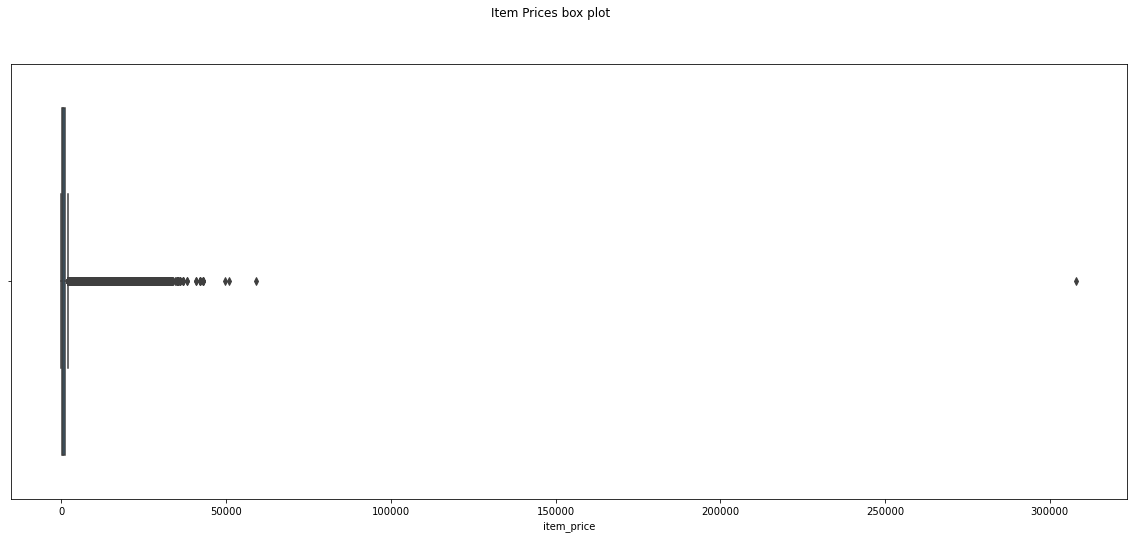

In [27]:
fig = plt.figure(figsize=(20, 8))
ax = plt.axes()
fig.suptitle("Item Prices box plot")
sns.boxplot(x=normData.item_price, ax=ax)
plt.show()

It seems that there is a extreme outlier and let's look further into the extreme outlier.

The sales_price is higher than 300000. 

In [28]:
normData[normData.item_price >= 300000]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_name,item_category_id,item_category_name
1163158,2013-12-13,11,12,6066,307980.0,1.0,Интернет-магазин ЧС,Radmin 3 - 522 лиц.,75,Программы - Для дома и офиса


Note: the result above will be empty if the remove parameter is set. 

It appears that there is only 1 item for item_price >= 300000. Let's check how many 6066 item_id in the data set. 

In [29]:
print("Number of record with item_id 6066: {}".format(len(normData[normData.item_id == 6066])))

Number of record with item_id 6066: 1


Only 1 record therefore we can definately delete the outlier. 

In [30]:
normData = normData[normData.item_price < 300000]

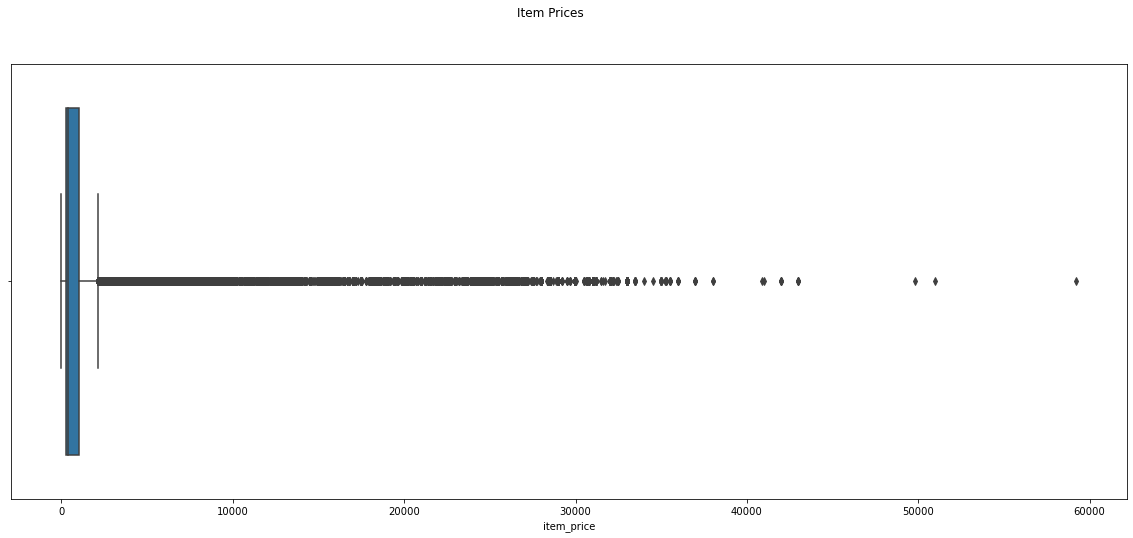

In [31]:
fig = plt.figure(figsize=(20, 8))
ax = plt.axes()
fig.suptitle("Item Prices")
sns.boxplot(x=normData.item_price, ax=ax)
plt.show()

**1.2.4 Check item count**

In [32]:
normData.item_cnt_day.describe()

count    2.935848e+06
mean     1.242641e+00
std      2.618835e+00
min     -2.200000e+01
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      2.169000e+03
Name: item_cnt_day, dtype: float64

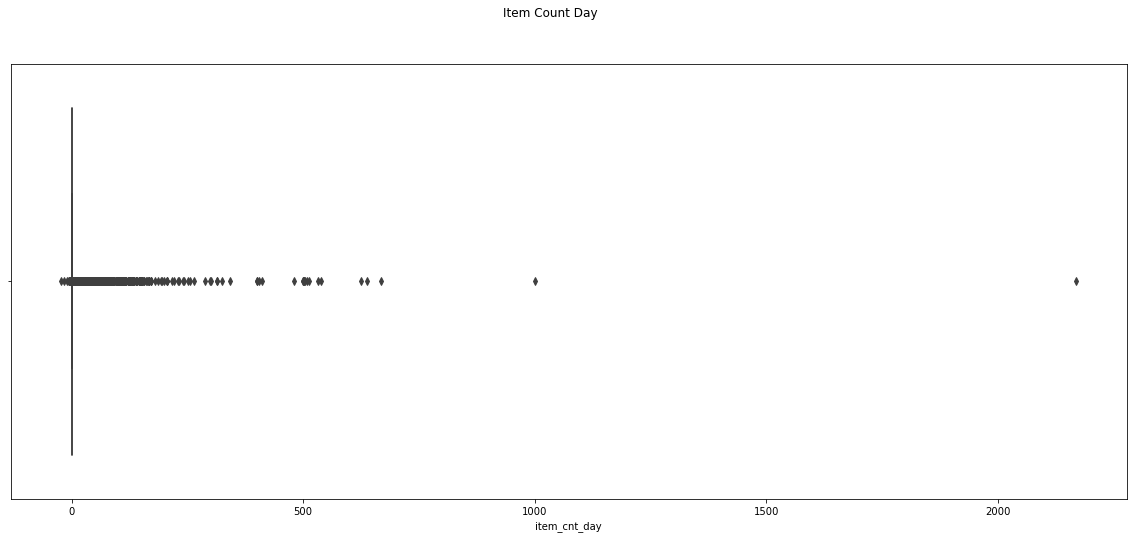

In [33]:
fig = plt.figure(figsize=(20, 8))
ax = plt.axes()
fig.suptitle("Item Count Day")
sns.boxplot(x=normData.item_cnt_day, ax=ax)
plt.show()

Let's check the outlier 

In [34]:
checkItemCnt = normData[normData.item_cnt_day >= 500]

checkItemCnt

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_name,item_category_id,item_category_name
1573253,2014-04-22,15,27,8057,1200.000000,502.0,"Москва ТЦ ""МЕГА Белая Дача II""",iTunes 1500 руб.,32,"Карты оплаты (Кино, Музыка, Игры)"
1708207,2014-06-28,17,25,20949,5.000000,501.0,"Москва ТРК ""Атриум""",Фирменный пакет майка 1С Интерес белый (34*42)...,71,"Подарки - Сумки, Альбомы, Коврики д/мыши"
2048518,2014-10-02,21,12,9242,1500.000000,512.0,Интернет-магазин ЧС,"Билет ""ИгроМир 2014"" (на один день (отдельно -...",8,Билеты (Цифра)
2067669,2014-10-09,21,55,19437,899.000000,508.0,Цифровой склад 1С-Онлайн,"Средиземье: Тени Мордора [PC, Цифровая версия]",31,Игры PC - Цифра
2257299,2014-12-19,23,12,20949,4.000000,500.0,Интернет-магазин ЧС,Фирменный пакет майка 1С Интерес белый (34*42)...,71,"Подарки - Сумки, Альбомы, Коврики д/мыши"
2326930,2015-01-15,24,12,20949,4.000000,1000.0,Интернет-магазин ЧС,Фирменный пакет майка 1С Интерес белый (34*42)...,71,"Подарки - Сумки, Альбомы, Коврики д/мыши"
2608040,2015-04-14,27,12,3731,1904.548077,624.0,Интернет-магазин ЧС,"Grand Theft Auto V [PC, русские субтитры]",30,Игры PC - Стандартные издания
2626181,2015-05-19,28,12,11373,155.192950,539.0,Интернет-магазин ЧС,Доставка до пункта выдачи (Boxberry),9,Доставка товара
2851073,2015-09-29,32,55,9249,1500.000000,533.0,Цифровой склад 1С-Онлайн,"Билет ""ИгроМир 2015"" - 3 октября 2015 (сайт) У...",8,Билеты (Цифра)
2851091,2015-09-30,32,55,9249,1702.825746,637.0,Цифровой склад 1С-Онлайн,"Билет ""ИгроМир 2015"" - 3 октября 2015 (сайт) У...",8,Билеты (Цифра)


In [35]:
for idx in checkItemCnt.index:
    id = checkItemCnt.loc[idx, "item_id"]
    checkItemCnt.loc[idx, "Required"] = id in testUniID

checkItemCnt.sort_values(by= "item_id")
    
#checkItemCnt[checkItemCnt.Required == True]

C:\Users\KANGHEA\Anaconda3\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\KANGHEA\Anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_name,item_category_id,item_category_name,Required
2608040,2015-04-14,27,12,3731,1904.548077,624.0,Интернет-магазин ЧС,"Grand Theft Auto V [PC, русские субтитры]",30,Игры PC - Стандартные издания,True
1573253,2014-04-22,15,27,8057,1200.000000,502.0,"Москва ТЦ ""МЕГА Белая Дача II""",iTunes 1500 руб.,32,"Карты оплаты (Кино, Музыка, Игры)",False
2048518,2014-10-02,21,12,9242,1500.000000,512.0,Интернет-магазин ЧС,"Билет ""ИгроМир 2014"" (на один день (отдельно -...",8,Билеты (Цифра),False
2864235,2015-09-30,32,12,9248,1692.526158,669.0,Интернет-магазин ЧС,"Билет ""ИгроМир 2015"" - 3 октября 2015 (сайт) [...",80,Служебные - Билеты,False
2864260,2015-09-29,32,12,9248,1500.000000,504.0,Интернет-магазин ЧС,"Билет ""ИгроМир 2015"" - 3 октября 2015 (сайт) [...",80,Служебные - Билеты,False
2851073,2015-09-29,32,55,9249,1500.000000,533.0,Цифровой склад 1С-Онлайн,"Билет ""ИгроМир 2015"" - 3 октября 2015 (сайт) У...",8,Билеты (Цифра),False
2851091,2015-09-30,32,55,9249,1702.825746,637.0,Цифровой склад 1С-Онлайн,"Билет ""ИгроМир 2015"" - 3 октября 2015 (сайт) У...",8,Билеты (Цифра),False
2626181,2015-05-19,28,12,11373,155.192950,539.0,Интернет-магазин ЧС,Доставка до пункта выдачи (Boxberry),9,Доставка товара,True
2909818,2015-10-28,33,12,11373,0.908714,2169.0,Интернет-магазин ЧС,Доставка до пункта выдачи (Boxberry),9,Доставка товара,True
2067669,2014-10-09,21,55,19437,899.000000,508.0,Цифровой склад 1С-Онлайн,"Средиземье: Тени Мордора [PC, Цифровая версия]",31,Игры PC - Цифра,False


It appears that some of the item_id do have high item_cnt_day number. 

Let's look further into 3731 and 8057 as they only have 1 rows

In [36]:
checkItemCnt = normData[normData.item_id == 3731]

checkItemCnt.sort_values(by = 'item_cnt_day')

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_name,item_category_id,item_category_name
2625897,2015-05-28,28,12,3731,1999.000000,-1.0,Интернет-магазин ЧС,"Grand Theft Auto V [PC, русские субтитры]",30,Игры PC - Стандартные издания
2904514,2015-10-15,33,53,3731,2199.000000,-1.0,"Уфа ТЦ ""Семья"" 2","Grand Theft Auto V [PC, русские субтитры]",30,Игры PC - Стандартные издания
2813516,2015-08-13,31,3,3731,1999.000000,-1.0,"Балашиха ТРК ""Октябрь-Киномир""","Grand Theft Auto V [PC, русские субтитры]",30,Игры PC - Стандартные издания
2703993,2015-06-18,29,4,3731,1999.000000,-1.0,"Волжский ТЦ ""Волга Молл""","Grand Theft Auto V [PC, русские субтитры]",30,Игры PC - Стандартные издания
2728024,2015-07-04,30,16,3731,1999.000000,-1.0,"Коломна ТЦ ""Рио""","Grand Theft Auto V [PC, русские субтитры]",30,Игры PC - Стандартные издания
...,...,...,...,...,...,...,...,...,...,...
2605020,2015-04-14,27,18,3731,1930.034483,145.0,"Красноярск ТЦ ""Июнь""","Grand Theft Auto V [PC, русские субтитры]",30,Игры PC - Стандартные издания
2555809,2015-04-14,27,31,3731,1946.953216,171.0,"Москва ТЦ ""Семеновский""","Grand Theft Auto V [PC, русские субтитры]",30,Игры PC - Стандартные издания
2567454,2015-04-14,27,25,3731,1941.995169,207.0,"Москва ТРК ""Атриум""","Grand Theft Auto V [PC, русские субтитры]",30,Игры PC - Стандартные издания
2597018,2015-04-14,27,42,3731,1918.732441,299.0,"СПб ТК ""Невский Центр""","Grand Theft Auto V [PC, русские субтитры]",30,Игры PC - Стандартные издания


In [37]:
checkItemCnt = normData[normData.item_id == 8057]

checkItemCnt.sort_values(by = 'item_cnt_day')

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_name,item_category_id,item_category_name
807027,2013-08-24,7,28,8057,1500.0,1.0,"Москва ТЦ ""МЕГА Теплый Стан"" II",iTunes 1500 руб.,32,"Карты оплаты (Кино, Музыка, Игры)"
1596496,2014-04-28,15,42,8057,1500.0,1.0,"СПб ТК ""Невский Центр""",iTunes 1500 руб.,32,"Карты оплаты (Кино, Музыка, Игры)"
1596497,2014-04-04,15,42,8057,1500.0,1.0,"СПб ТК ""Невский Центр""",iTunes 1500 руб.,32,"Карты оплаты (Кино, Музыка, Игры)"
1599851,2014-04-25,15,44,8057,1500.0,1.0,"Самара ТЦ ""Мелодия""",iTunes 1500 руб.,32,"Карты оплаты (Кино, Музыка, Игры)"
1631422,2014-05-24,16,27,8057,1500.0,1.0,"Москва ТЦ ""МЕГА Белая Дача II""",iTunes 1500 руб.,32,"Карты оплаты (Кино, Музыка, Игры)"
...,...,...,...,...,...,...,...,...,...,...
2043157,2014-10-01,21,27,8057,1500.0,11.0,"Москва ТЦ ""МЕГА Белая Дача II""",iTunes 1500 руб.,32,"Карты оплаты (Кино, Музыка, Игры)"
1571406,2014-04-23,15,21,8057,1200.0,100.0,"Москва МТРЦ ""Афи Молл""",iTunes 1500 руб.,32,"Карты оплаты (Кино, Музыка, Игры)"
1618930,2014-04-23,15,29,8057,1200.0,240.0,"Москва ТЦ ""Новый век"" (Новокосино)",iTunes 1500 руб.,32,"Карты оплаты (Кино, Музыка, Игры)"
1573252,2014-04-23,15,27,8057,1200.0,401.0,"Москва ТЦ ""МЕГА Белая Дача II""",iTunes 1500 руб.,32,"Карты оплаты (Кино, Музыка, Игры)"


Based on the section above, it item_cnd_day for 3731 and 8057 seem normal. Their item counts is normal comparing the same item id. 


## 2. Exploratory Data Analysis

First we will need to add date related new columns for better analysis 

In [38]:
normData['date_month'] = normData['date'].dt.month
normData['date_year'] = normData['date'].dt.year
#Calculate total normData
normData['total_sales'] =  normData['item_price'] * normData['item_cnt_day']

Prepare the sales year split by year for reusability

**Run code below to get the cleaned data as CSV**

In [39]:
#Save data as CSV file

normData.to_csv('predictFutureSalesClean.csv') 

In [40]:
sales2013 = normData[normData['date_year'] == 2013]
sales2014 = normData[normData['date_year'] == 2014]
sales2015 = normData[normData['date_year'] == 2015]

### 2.1 General Sales Trend

In [41]:
# Find aggregate sales by day
salesMonYea2013 = sales2013.groupby(['date_month','date_year'])[['total_sales']].agg('sum').reset_index()
salesMonYea2014 = sales2014.groupby(['date_month','date_year'])[['total_sales']].agg('sum').reset_index()
salesMonYea2015 = sales2015.groupby(['date_month','date_year'])[['total_sales']].agg('sum').reset_index()

totalSales = pd.concat([salesMonYea2013,salesMonYea2014,salesMonYea2015])

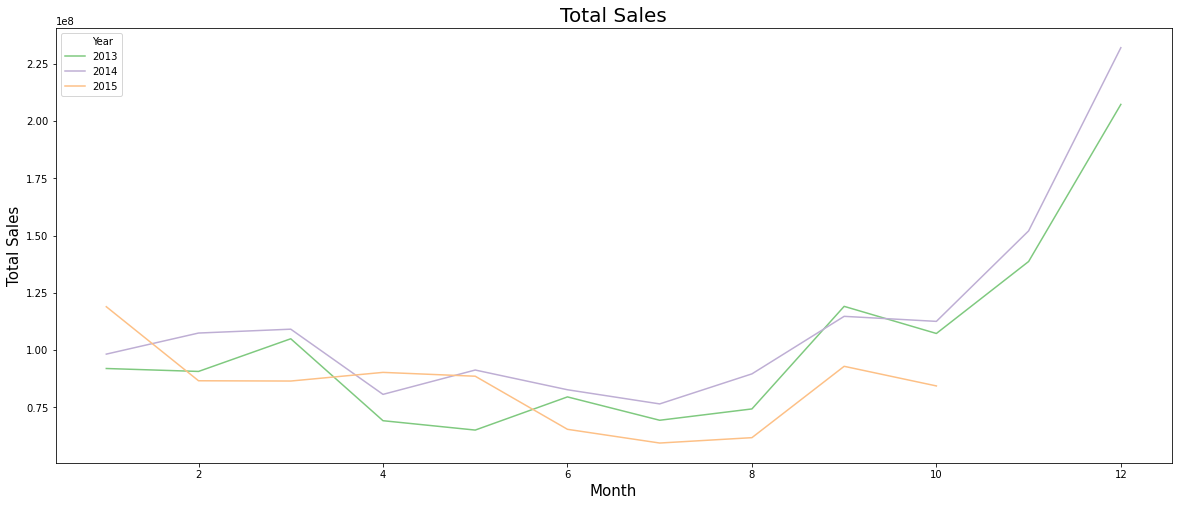

In [42]:
fig0,ax0=plt.subplots(figsize=(20,8));
sns.lineplot(x='date_month', y = 'total_sales', data = totalSales,
           hue='date_year', palette = 'Accent')

plt.title("Total Sales", fontsize = 20)
plt.xlabel("Month", fontsize = 15)
plt.ylabel("Total Sales", fontsize = 15)
legend = ax0.legend()
legend.texts[0].set_text("Year")
plt.show()

Let's look at the heatmap for sales trend

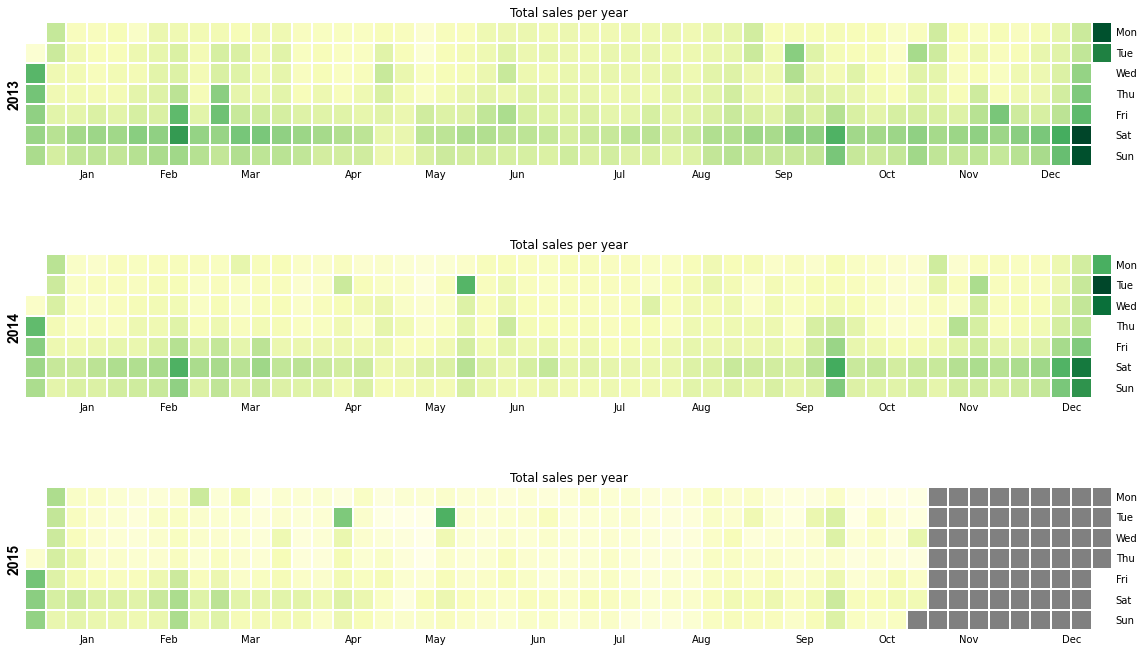

In [43]:
calHeatMap = normData[["date", "item_cnt_day"]]

calHeatMap.set_index("date", inplace = True)

calHeatMap = calHeatMap.resample("D")["item_cnt_day"].sum()

calmap.calendarplot(calHeatMap, # pass the series
                    fig_kws = {'figsize': (16,10)}, 
                    cmap='YlGn',
                    fillcolor='grey',
                    yearlabel_kws = {'color':'black', 'fontsize':14}, 
                    subplot_kws = {'title':'Total sales per year'}
                   );

Let's check item count trend as well

In [44]:
# Find aggregate sales by day
itemCntYea2013 = sales2013.groupby(['date_month','date_year'])[['item_cnt_day']].agg('sum').reset_index()
itemCntYea2014 = sales2014.groupby(['date_month','date_year'])[['item_cnt_day']].agg('sum').reset_index()
itemCntYea2015 = sales2015.groupby(['date_month','date_year'])[['item_cnt_day']].agg('sum').reset_index()

itemCntYea = pd.concat([itemCntYea2013,itemCntYea2014,itemCntYea2015])

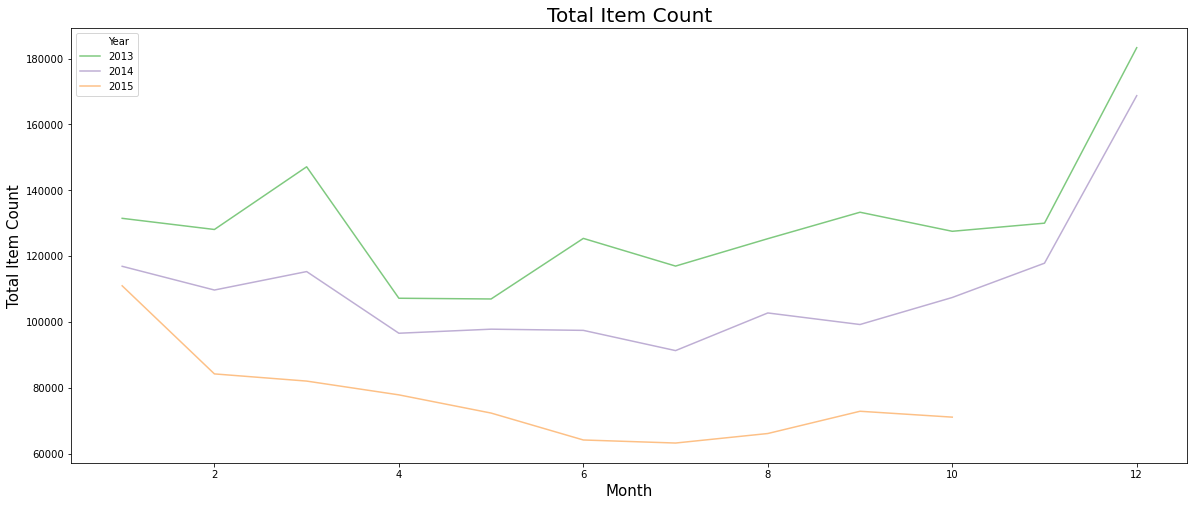

In [45]:
fig0,ax0=plt.subplots(figsize=(20,8));
sns.lineplot(x='date_month', y = 'item_cnt_day', data = itemCntYea,
           hue='date_year', palette = 'Accent')

plt.title("Total Item Count", fontsize = 20)
plt.xlabel("Month", fontsize = 15)
plt.ylabel("Total Item Count", fontsize = 15)
legend = ax0.legend()
legend.texts[0].set_text("Year")
plt.show()

### 2.2 Items

In [46]:

item_sales = normData.groupby(['item_id'])[['total_sales']].agg('sum').reset_index()

item_sales

,item_id,total_sales
0,0,58.00
1,1,26940.00
2,2,116.00
3,3,158.00
4,4,58.00
...,...,...
21801,22165,118.00
21802,22166,52200.00
21803,22167,393108.75
21804,22168,4793.50


Let's explore the graph for Top 10 Total Sales by Item

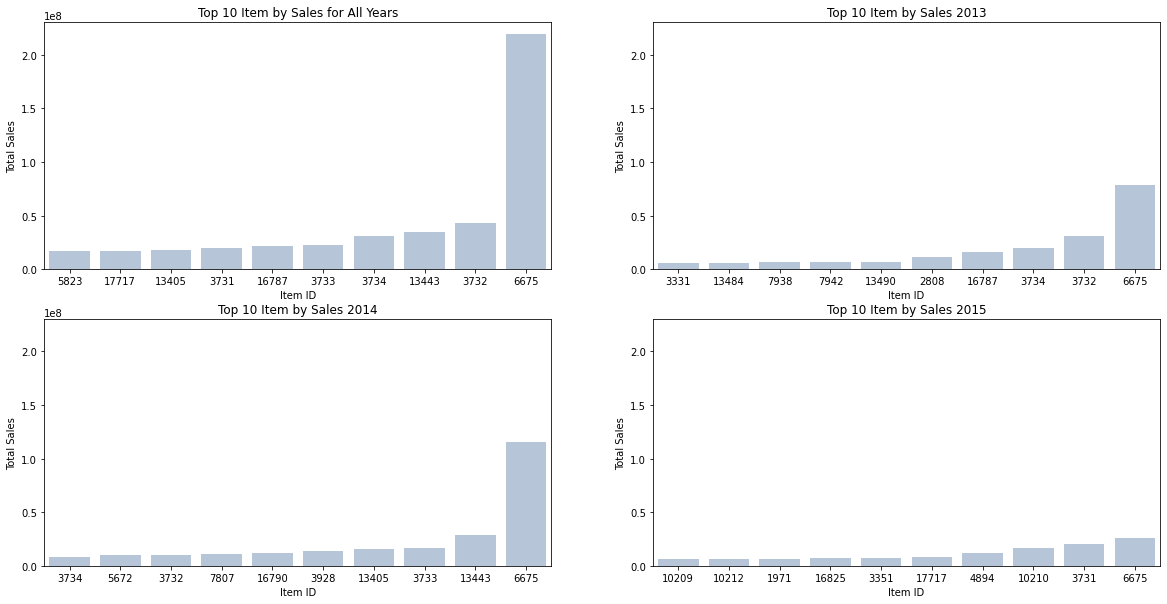

In [47]:
def buildItemSalesGraph(df,ax0,year):
    
    item_sales = df.groupby(['item_id'])[['total_sales']].agg('sum').reset_index()
    
    item_sales = item_sales.sort_values(by=['total_sales'], ascending =False)

    item_sales = item_sales.head(n = 10)
    
    axTotal= sns.barplot(ax=ax0, x = item_sales.item_id, 
                y = item_sales.total_sales,
               order= item_sales.sort_values('total_sales').item_id,
                color = 'lightsteelblue')
   
    if year == '':
        axTotal.title.set_text('Top 10 Item by Sales for All Years')
    else: 
        title = 'Top 10 Item by Sales ' + str(year)
        axTotal.title.set_text(title)
    
    axTotal.set_xlabel('Item ID')
    axTotal.set_ylabel('Total Sales')
    axTotal.yaxis.set_tick_params(labelbottom=True)
    
# Checking best item selling by sales - Top 10
# Prepare subplots
fig, axes = plt.subplots(2, 2, figsize=(20, 10), sharey=True)

buildItemSalesGraph(normData,axes[0,0],'')
buildItemSalesGraph(sales2013,axes[0,1],2013)
buildItemSalesGraph(sales2014,axes[1,0],2014)
buildItemSalesGraph(sales2015,axes[1,1],2015)

Let's explore the graph for Top 10 Total Sales by Item

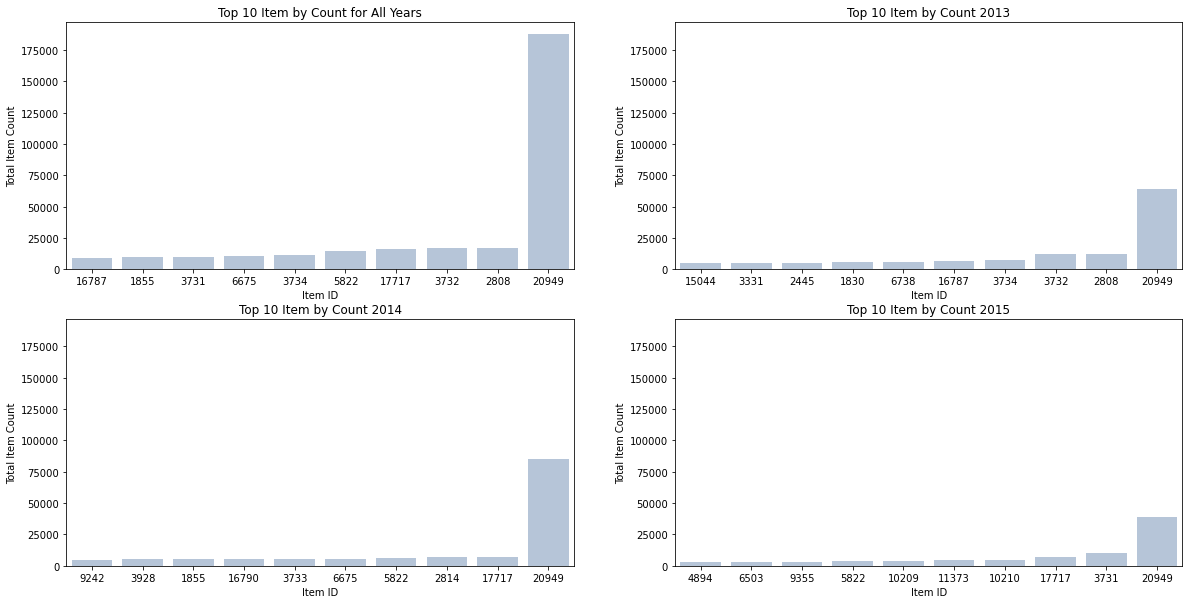

In [48]:
def buildItemCntGraph(df,ax0,year):

    sales_item_cnt = df.groupby(['item_id'])[['item_cnt_day']].agg('sum').reset_index()

    sales_item_cnt = sales_item_cnt.sort_values(by=['item_cnt_day'], ascending =False)

    sales_item_cnt = sales_item_cnt.head(n = 10)

    ax= sns.barplot(ax=ax0, x = sales_item_cnt.item_id, 
                y = sales_item_cnt.item_cnt_day,
               order=sales_item_cnt.sort_values('item_cnt_day').item_id,
                   color = 'lightsteelblue')
    
    if year == '':
        ax.title.set_text('Top 10 Item by Count for All Years')
    else: 
        title = 'Top 10 Item by Count ' + str(year)
        ax.title.set_text(title)
    
    ax.set_xlabel('Item ID')
    ax.set_ylabel('Total Item Count')
    ax.yaxis.set_tick_params(labelbottom=True)
    
# Checking best item selling by sales - Top 10
# Prepare subplots
fig, axes = plt.subplots(2, 2, figsize=(20, 10), sharey=True)

buildItemCntGraph(normData,axes[0,0],'')
buildItemCntGraph(sales2013,axes[0,1],2013)
buildItemCntGraph(sales2014,axes[1,0],2014)
buildItemCntGraph(sales2015,axes[1,1],2015)

### 2.3 Shop 

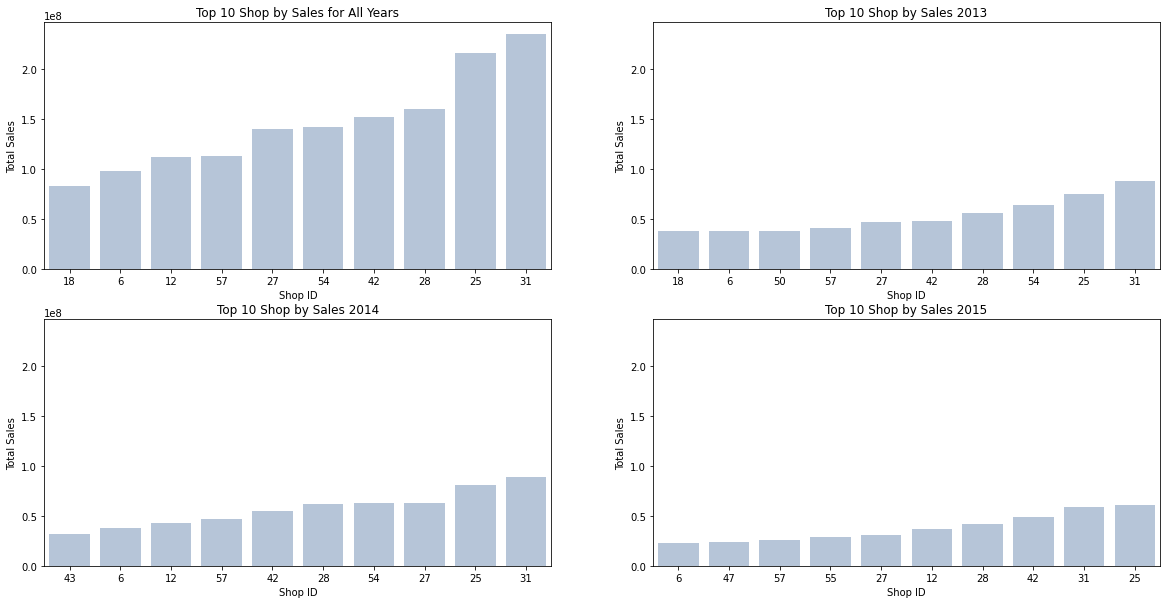

In [49]:
# Checking Shop with top 10 Sales
# Prepare subplots
def buildShopSalesGraph(df,ax0,year):

    sales_shop = df.groupby(['shop_id'])[['total_sales']].agg('sum').reset_index()

    sales_shop = sales_shop.sort_values(by=['total_sales'], ascending =False)

    sales_shop = sales_shop.head(n = 10)

    ax= sns.barplot(ax=ax0, x = sales_shop.shop_id, 
                y = sales_shop.total_sales,
               order=sales_shop.sort_values('total_sales').shop_id,
                   color = 'lightsteelblue')
    
    if year == '':
        ax.title.set_text('Top 10 Shop by Sales for All Years')
    else: 
        title = 'Top 10 Shop by Sales ' + str(year)
        ax.title.set_text(title)
    
    ax.set_xlabel('Shop ID')
    ax.set_ylabel('Total Sales')
    ax.yaxis.set_tick_params(labelbottom=True)

# Checking best item selling by sales - Top 10
# Prepare subplots
fig, axes = plt.subplots(2, 2, figsize=(20, 10), sharey=True)

buildShopSalesGraph(normData,axes[0,0],'')
buildShopSalesGraph(sales2013,axes[0,1],2013)
buildShopSalesGraph(sales2014,axes[1,0],2014)
buildShopSalesGraph(sales2015,axes[1,1],2015)

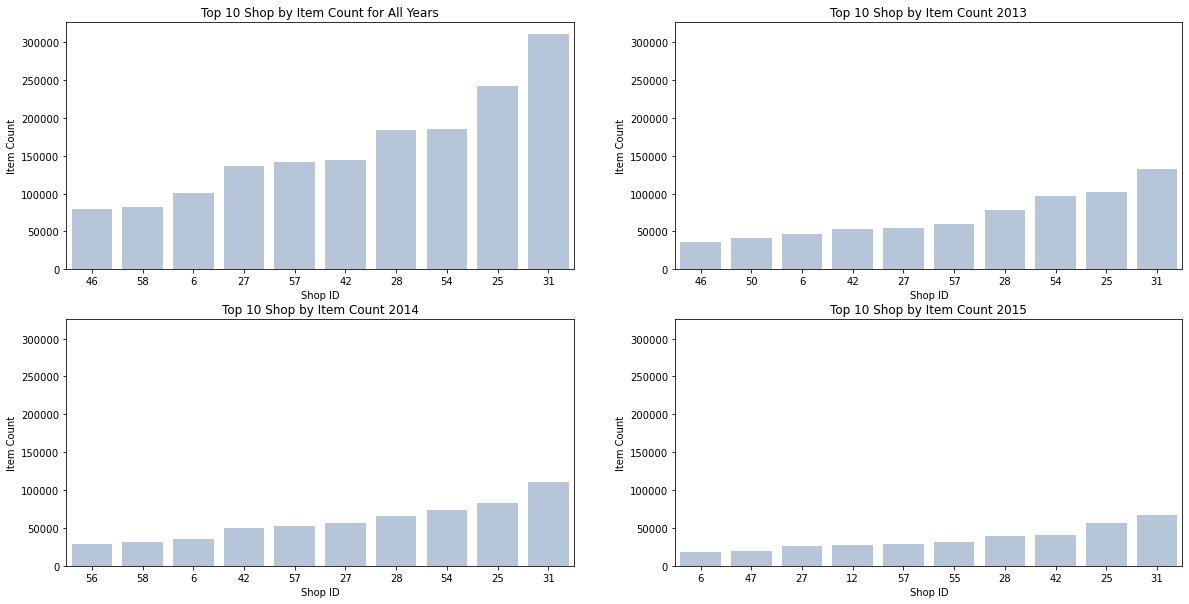

In [50]:
# Checking Top 10 shop with Item count
# Prepare subplots
def buildShopCntGraph(df,ax0,year):

    sales_shop = df.groupby(['shop_id'])[['item_cnt_day']].agg('sum').reset_index()

    sales_shop = sales_shop.sort_values(by=['item_cnt_day'], ascending =False)

    sales_shop = sales_shop.head(n = 10)

    ax= sns.barplot(ax=ax0, x = sales_shop.shop_id, 
                y = sales_shop.item_cnt_day,
               order=sales_shop.sort_values('item_cnt_day').shop_id,
                   color = 'lightsteelblue')
    
    if year == '':
        ax.title.set_text('Top 10 Shop by Item Count for All Years')
    else: 
        title = 'Top 10 Shop by Item Count ' + str(year)
        ax.title.set_text(title)
    
    ax.set_xlabel('Shop ID')
    ax.set_ylabel('Item Count')
    ax.yaxis.set_tick_params(labelbottom=True)

# Checking best item selling by sales - Top 10
# Prepare subplots
fig, axes = plt.subplots(2, 2, figsize=(20, 10),sharey=True)

buildShopCntGraph(normData,axes[0,0],'')
buildShopCntGraph(sales2013,axes[0,1],2013)
buildShopCntGraph(sales2014,axes[1,0],2014)
buildShopCntGraph(sales2015,axes[1,1],2015)



### 2.4 Categories

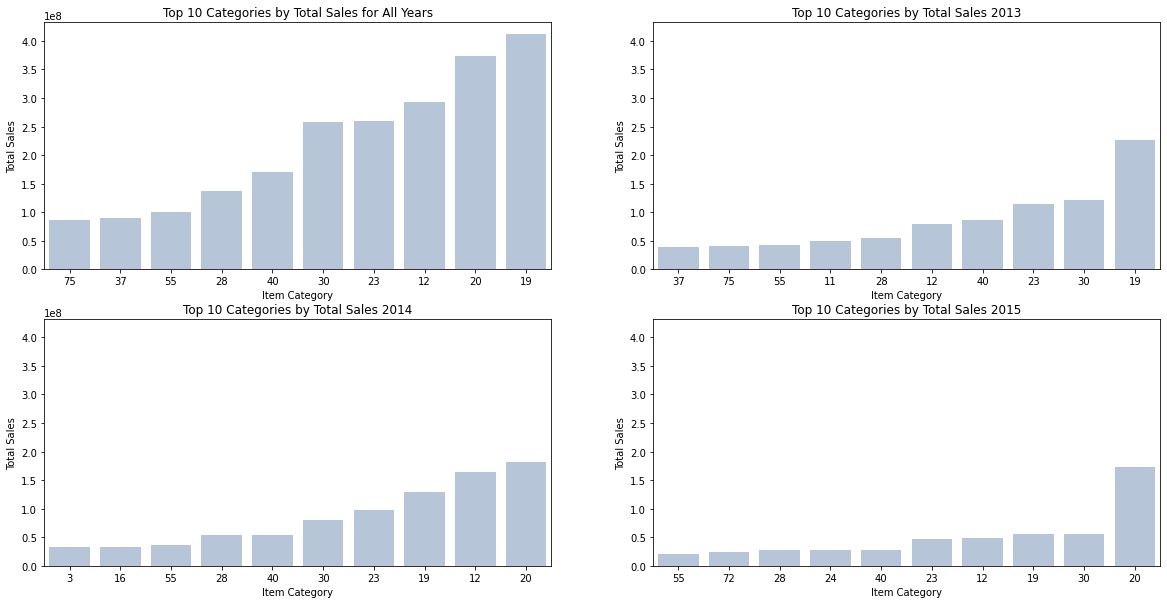

In [51]:
# Checking Top 10 shop with Item count
# Prepare subplots
def buildCatSalesGraph(df,ax0,year):

    sales_cat = df.groupby(['item_category_id'])[['total_sales']].agg('sum').reset_index()

    sales_cat = sales_cat.sort_values(by=['total_sales'], ascending =False)

    sales_cat = sales_cat.head(n = 10)

    ax= sns.barplot(ax=ax0, x = sales_cat.item_category_id, 
                y = sales_cat.total_sales,
               order=sales_cat.sort_values('total_sales').item_category_id,
                   color = 'lightsteelblue')
    
    if year == '':
        ax.title.set_text('Top 10 Categories by Total Sales for All Years')
    else: 
        title = 'Top 10 Categories by Total Sales ' + str(year)
        ax.title.set_text(title)
    
    ax.set_xlabel('Item Category')
    ax.set_ylabel('Total Sales')
    ax.yaxis.set_tick_params(labelbottom=True)

# Checking best item selling by sales - Top 10
# Prepare subplots
fig, axes = plt.subplots(2, 2, figsize=(20, 10),sharey=True)

buildCatSalesGraph(normData,axes[0,0],'')
buildCatSalesGraph(sales2013,axes[0,1],2013)
buildCatSalesGraph(sales2014,axes[1,0],2014)
buildCatSalesGraph(sales2015,axes[1,1],2015)

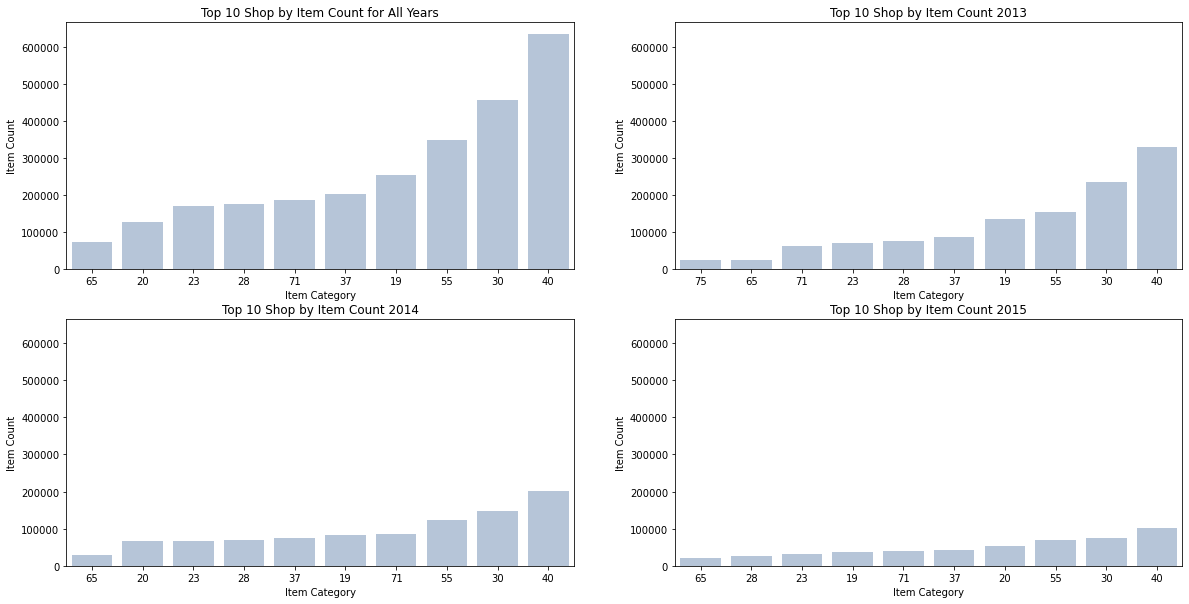

In [52]:
# Checking Top 10 shop with Item count
# Prepare subplots
def buildCatCntGraph(df,ax0,year):

    sales_cat = df.groupby(['item_category_id'])[['item_cnt_day']].agg('sum').reset_index()

    sales_cat = sales_cat.sort_values(by=['item_cnt_day'], ascending =False)

    sales_cat = sales_cat.head(n = 10)

    ax= sns.barplot(ax=ax0, x = sales_cat.item_category_id, 
                y = sales_cat.item_cnt_day,
               order=sales_cat.sort_values('item_cnt_day').item_category_id,
                   color = 'lightsteelblue')
    
    if year == '':
        ax.title.set_text('Top 10 Shop by Item Count for All Years')
    else: 
        title = 'Top 10 Shop by Item Count ' + str(year)
        ax.title.set_text(title)
    
    ax.set_xlabel('Item Category')
    ax.set_ylabel('Item Count')
    ax.yaxis.set_tick_params(labelbottom=True)

# Checking best item selling by sales - Top 10
# Prepare subplots
fig, axes = plt.subplots(2, 2, figsize=(20, 10),sharey=True)

buildCatCntGraph(normData,axes[0,0],'')
buildCatCntGraph(sales2013,axes[0,1],2013)
buildCatCntGraph(sales2014,axes[1,0],2014)
buildCatCntGraph(sales2015,axes[1,1],2015)

